### Import Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("../data/Bad_Nozzle_set1.csv")

print(f"Number of data points: {len(df)}")
print(f"Start Time: {df['Time'].iloc[0]}")
print(f"End Time: {df['Time'].iloc[-1]}")
print(f"Duration (mins): {len(df) / 60:.2f} mins")

df.head()


Number of data points: 960
Start Time: 4:20:45 pm
End Time: 4:36:44 pm
Duration (mins): 16.00 mins


,Date,Time,ms,Data_Type,ABB_X,ABB_Y,ABB_Z,Chamber_Temp,Chamber_Pressure,Main_Gas_Flow,PF1_Gas_Flow,PF2_Gas_Flow,PF1_LibraWeight,PF2_LibraWeight,PF1_Pressure,PF2_Pressure
0,4/12/2024,4:20:45 pm,0,Double[12],-509.83,-2213.82,1278.23,61,0.021,1,20.8,0,62.26,62.65,0.220,0.002
1,4/12/2024,4:20:46 pm,0,Double[12],-509.83,-2213.82,1278.23,62,0.019,1,17.0,0,62.26,62.65,0.195,0.002
2,4/12/2024,4:20:47 pm,0,Double[12],-509.83,-2213.82,1278.23,63,0.016,1,10.2,0,62.26,62.65,0.170,0.002
3,4/12/2024,4:20:48 pm,0,Double[12],-509.83,-2213.82,1278.23,64,0.016,1,8.0,0,62.26,62.65,0.147,0.000
4,4/12/2024,4:20:49 pm,0,Double[12],-509.83,-2213.82,1278.23,64,0.021,1,7.2,0,62.26,62.65,0.130,0.002


### Exploratory Data Analysis (EDA)

In [2]:
import matplotlib.pyplot as plt

def plot_columns_in_grid(filtered_df, y_columns, nrows=1, ncols=3, figsize=(15, 5)):
    """
    Plots multiple columns of a DataFrame in a grid of subplots.

    Parameters:
        filtered_df (pd.DataFrame): The DataFrame containing the data to plot.
        y_columns (list): List of column names to plot.
        nrows (int): Number of rows in the grid.
        ncols (int): Number of columns in the grid.
        figsize (tuple): Figure size.

    Returns:
        None
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Plot each column in the corresponding subplot
    for i, column in enumerate(y_columns):
        if i < len(axes):  # Avoid indexing errors
            ax = axes[i]
            ax.plot(filtered_df[column], marker='.', label=column)
            ax.set_title(column, fontsize=10)
            ax.legend(fontsize=8)
            ax.grid(True)
            ax.get_xaxis().set_visible(False)  # Hide x-axis
            ax.set_ylabel(column, fontsize=8)

    # Remove unused subplots
    for i in range(len(y_columns), len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()
    plt.show()


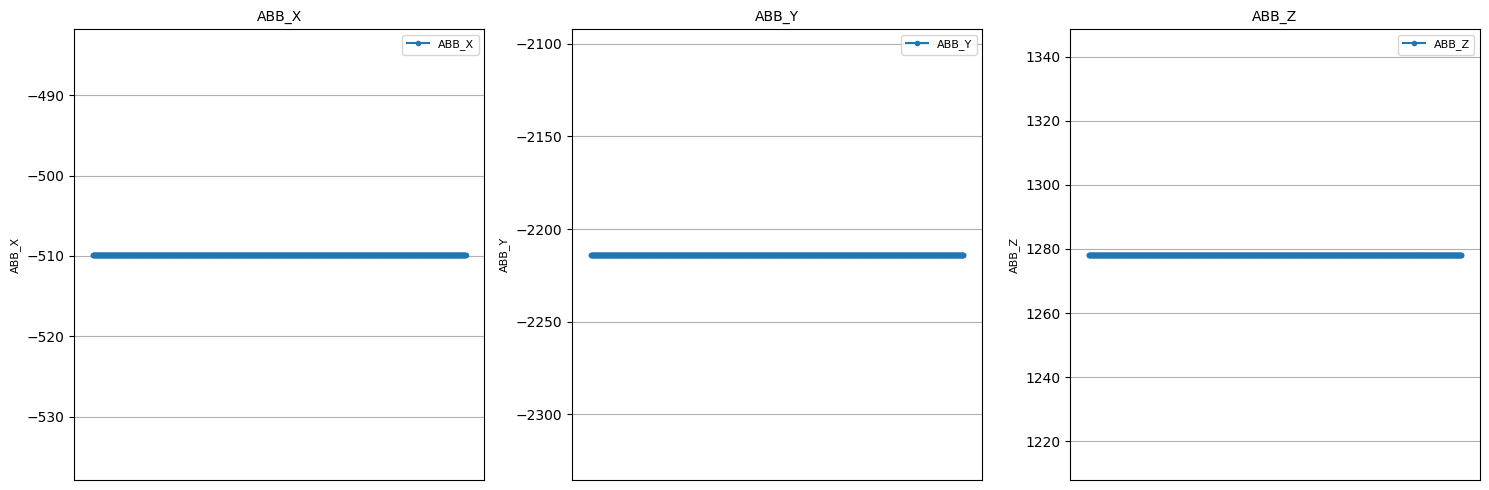

In [3]:
# List of columns for y-axis
y_columns = ["ABB_X", "ABB_Y", "ABB_Z"]
plot_columns_in_grid(df, y_columns, nrows=1, ncols=3)


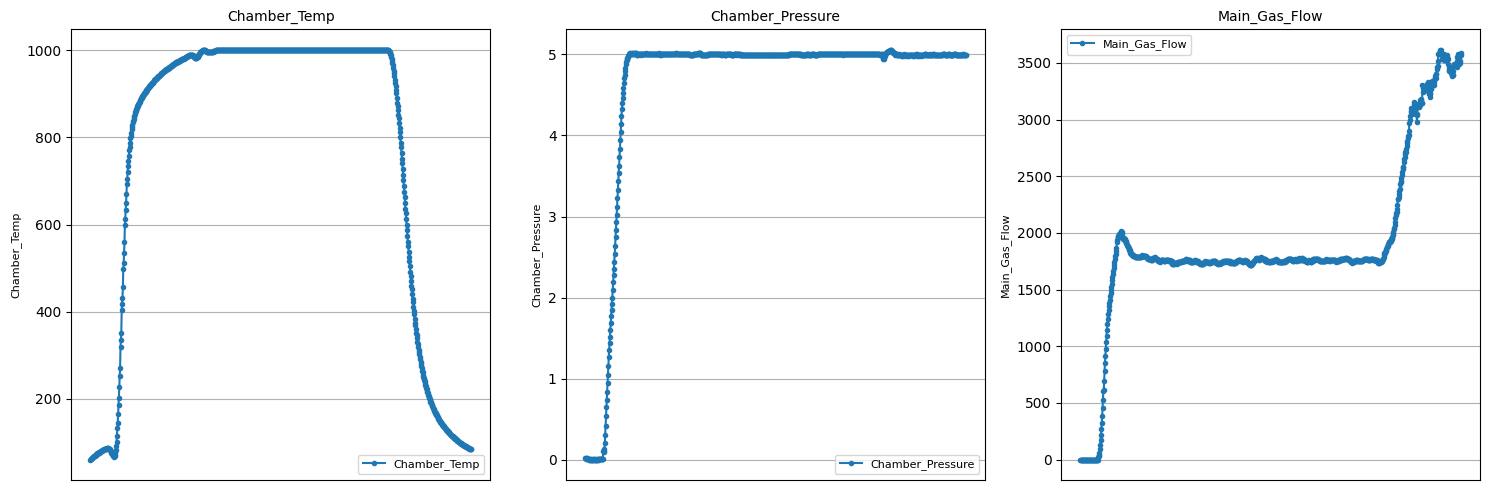

In [4]:
# List of columns for y-axis
y_columns = ["Chamber_Temp", "Chamber_Pressure", "Main_Gas_Flow"]
plot_columns_in_grid(df, y_columns, nrows=1, ncols=3)


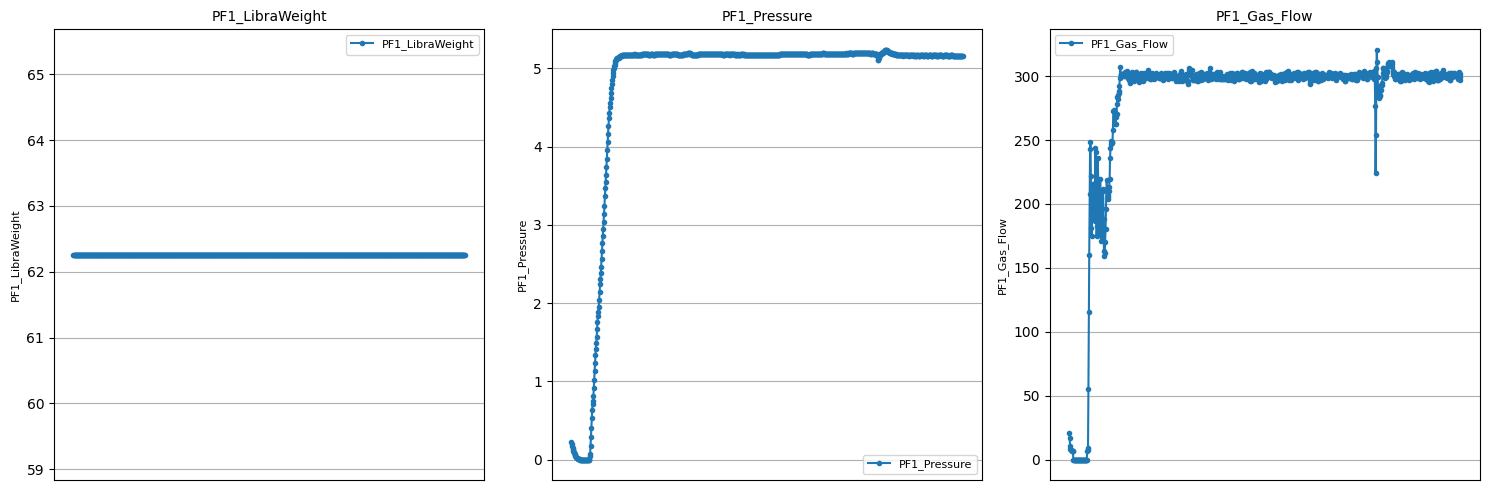

In [5]:
# List of columns for y-axis
y_columns = ["PF1_LibraWeight", "PF1_Pressure", "PF1_Gas_Flow"]
plot_columns_in_grid(df, y_columns, nrows=1, ncols=3)


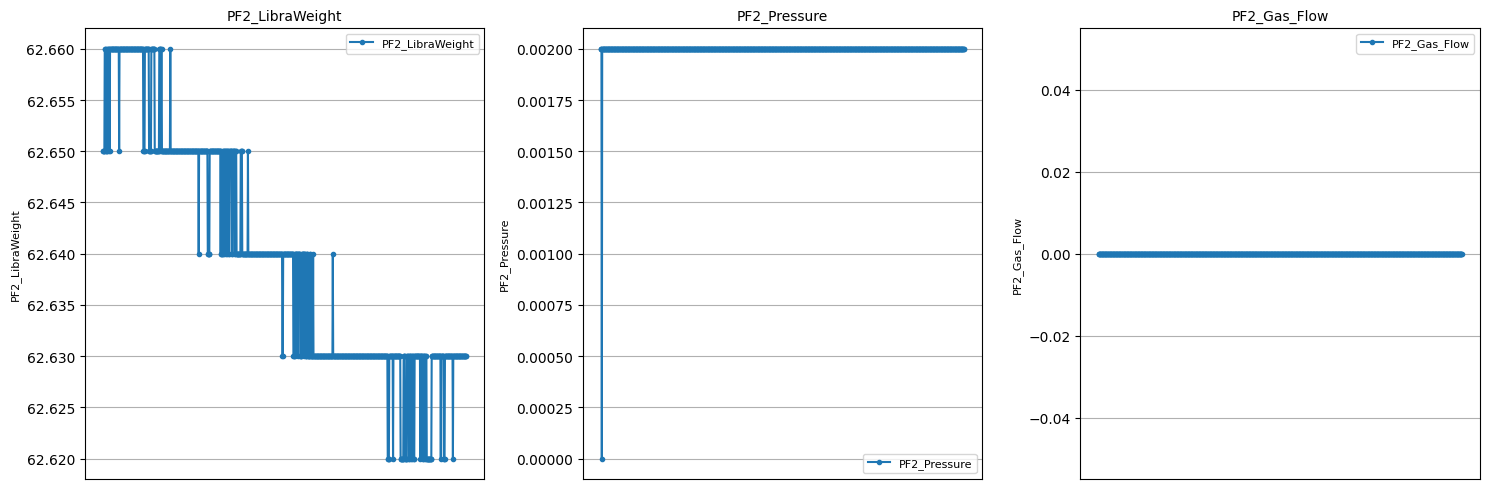

In [6]:
# List of columns for y-axis
y_columns = ["PF2_LibraWeight", "PF2_Pressure", "PF2_Gas_Flow"]
plot_columns_in_grid(df, y_columns, nrows=1, ncols=3)


In [ ]:
import seaborn as sns
import numpy as np

pros_param = ["Chamber_Pressure", "Main_Gas_Flow", "PF1_Gas_Flow", "PF1_Pressure"]

# Filter the DataFrame for process parameters
pros_param_df = df[pros_param]

# Compute the covariance matrix
corr_matrix = pros_param_df.corr(method='spearman')  # or 'kendall'

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(corr_matrix)

# Analyze NaN values in the correlation matrix
nan_columns = corr_matrix.columns[corr_matrix.isnull().any()].tolist()
if nan_columns:
    print(f"\nColumns leading to NaN in correlation matrix: {nan_columns}")
    for col in nan_columns:
        print(f"Analysis for column '{col}':")
        if pros_param_df[col].std() == 0:
            print(" - This column has constant values.")
        elif pros_param_df[col].isnull().all():
            print(" - This column contains only NaN values.")
        else:
            print(" - Mixed values or other issues may exist.")
else:
    print("\nNo NaN values found in the correlation matrix.")

# Visualization (Optional)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()



### Unsupervised Learning

Mahalanobis Distance

In [ ]:
# Mahalanobis calculation function
def calculateMahalanobis(y=None, data=None, cov=None):
    y_mu = y - np.mean(data, axis=0)  # Compute row minus column mean
    if cov is None:  # If covariance is not provided, compute it
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)  # Invert covariance matrix
    left = np.dot(y_mu, inv_covmat)  # Intermediate step
    mahal = np.dot(left, y_mu.T)  # Calculate Mahalanobis distance
    return mahal.diagonal() if len(mahal.shape) > 1 else mahal

# Apply Mahalanobis calculation to each row
pros_param_df["Mahalanobis"] = pros_param_df[pros_param].apply(
    lambda row: calculateMahalanobis(
        y=row.values,
        data=pros_param_df[pros_param]
    ),
    axis=1
)

pros_param_df

In [ ]:
y_columns = ["Mahalanobis", "PF1_Pressure", "PF1_Gas_Flow"]
plot_columns_in_grid(pros_param_df, y_columns, nrows=1, ncols=3)

In [ ]:
y_columns = ["Mahalanobis", "Chamber_Pressure", "Main_Gas_Flow"]
plot_columns_in_grid(pros_param_df, y_columns, nrows=1, ncols=3)


Elliptic Envelope

In [ ]:
from sklearn.covariance import EllipticEnvelope

# Fit the EllipticEnvelope model
elliptic_env = EllipticEnvelope(contamination=0.1, random_state=42)  # Assume 10% contamination
elliptic_env.fit(pros_param_df[pros_param])

# Predict inliers and outliers
pros_param_df["Outlier"] = elliptic_env.predict(pros_param_df[pros_param])  # -1 for outliers, 1 for inliers

# Visualize results
plt.figure(figsize=(10, 6))
for feature in pros_param:
    plt.scatter(pros_param_df.index, pros_param_df[feature], c=pros_param_df["Outlier"], cmap='coolwarm', label=feature, marker='.')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("EllipticEnvelope Outlier Detection")
plt.xlabel("Index")
plt.ylabel("Feature Values")
plt.legend(pros_param, loc='upper left')
plt.show()

pros_param_df